In [ ]:
xcfrom google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np

# Card denominations and suits
denominations = ['A', '2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K']
suits = ['C', 'H', 'S', 'D']

# Generate labelMap
labelMap = {f"{denom}{suit}": idx for idx, (denom, suit) in enumerate((d, s) for d in denominations for s in suits)}

import os
import cv2
import numpy as np
import random

def augment_image(img):
    """Apply random augmentations to an image."""
    # Random brightness adjustment
    factor = random.uniform(0.8, 1.2)
    img = np.clip(img * factor, 0, 1)

    return img

def load_and_augment_card_images(img_dir, target_size=(128, 128), augment_per_image=5):
    """
    Load card images with augmentation to increase dataset size.

    Args:
        img_dir (str): Path to the directory containing card images
        target_size (tuple): Desired image resolution (width, height)
        augment_per_image (int): Number of augmented versions to generate per image

    Returns:
        tuple: (images, labels)
    """
    images = []
    labels = []
    i = 0

    for filename in os.listdir(img_dir):
        if filename.endswith('.jpg'):
            # Extract label from first two characters
            label_name = filename[:2]

            if label_name not in labelMap:
                continue

            label = labelMap[label_name]

            # Read image
            img_path = os.path.join(img_dir, filename)
            img = cv2.imread(img_path)

            # Resize to smaller dimensions
            img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

            # Normalize
            img = img / 255.0

            # Append original image
            images.append(img)
            labels.append(label)

            # Create augmented versions
            for _ in range(augment_per_image):
                augmented_img = augment_image(img)
                images.append(augmented_img)
                labels.append(label)

            i += 1
            if i % 10 == 0:
                print(f"{i} images processed")

    return np.array(images), np.array(labels)

# Usage
img_dir = '/content/drive/MyDrive/CV Final Train'
images, labels = load_and_augment_card_images(img_dir)

print(f"Total images: {len(images)}")
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

10 images processed
20 images processed
30 images processed
40 images processed
50 images processed
60 images processed
70 images processed
80 images processed
90 images processed
100 images processed
110 images processed
120 images processed
130 images processed
140 images processed
150 images processed
160 images processed
170 images processed
180 images processed
190 images processed
200 images processed
210 images processed
220 images processed
230 images processed
240 images processed
250 images processed
260 images processed
270 images processed
280 images processed
290 images processed
300 images processed
310 images processed
320 images processed
330 images processed
340 images processed
350 images processed
360 images processed
370 images processed
380 images processed
390 images processed
400 images processed
410 images processed
Total images: 2496
Images shape: (2496, 128, 128, 3)
Labels shape: (2496,)


In [ ]:
import numpy as np

def custom_train_val_split(images, labels):
    """
    Split images and labels into train and validation sets
    Splits every 48 images: 40 for train, 8 for validation

    Args:
        images (numpy.ndarray): Input images
        labels (numpy.ndarray): Corresponding labels

    Returns:
        tuple: (X_train, y_train, X_val, y_val)
    """
    # Ensure divisible by 8
    num_images = len(images)
    num_groups = num_images // 48

    X_train = []
    y_train = []
    X_val = []
    y_val = []

    for i in range(num_groups):
        group_start = i * 48
        group_end = group_start + 48

        # First 6 images in group go to training
        X_train.extend(images[group_start:group_start+40])
        y_train.extend(labels[group_start:group_start+40])

        # Last 2 images in group go to validation
        X_val.extend(images[group_start+40:group_end])
        y_val.extend(labels[group_start+40:group_end])

    # Convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)

    return X_train, y_train, X_val, y_val

# Usage
X_train, y_train, X_val, y_val = custom_train_val_split(images, labels)

print("Training set shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Validation set shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)

Training set shape: (2080, 128, 128, 3)
Training labels shape: (2080,)
Validation set shape: (416, 128, 128, 3)
Validation labels shape: (416,)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
)

# Fit generator to your training data
datagen.fit(X_train)

In [ ]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(52, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.0556 - loss: 3.9514 - val_accuracy: 0.2644 - val_loss: 3.2336
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.2071 - loss: 3.0529 - val_accuracy: 0.4111 - val_loss: 2.4974
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3510 - loss: 2.3827 - val_accuracy: 0.6466 - val_loss: 1.9070
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.4687 - loss: 1.8931 - val_accuracy: 0.7043 - val_loss: 1.5278
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5735 - loss: 1.4959 - val_accuracy: 0.7260 - val_loss: 1.2756
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6617 - loss: 1.2143 - val_accuracy: 0.7740 - val_loss: 1.0493
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7370 - loss: 1.0189 - val_accuracy: 0.8053 - val_loss: 0.9045
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7876 - loss: 0.8622 - val_accuracy: 0.7788 -

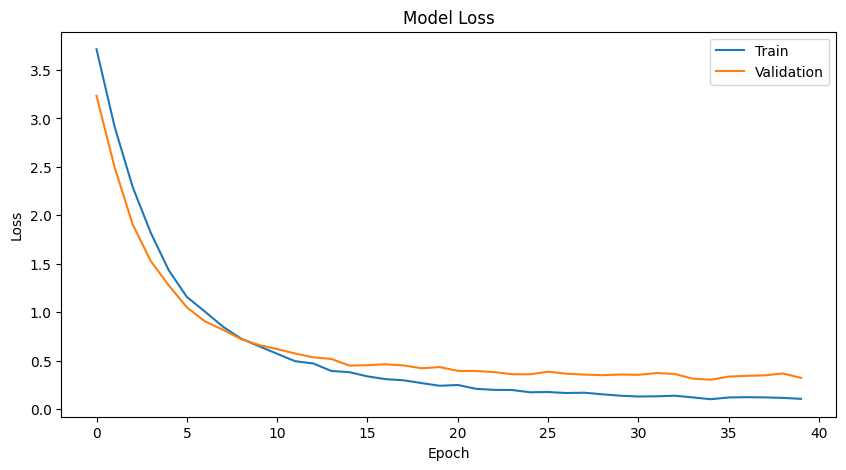

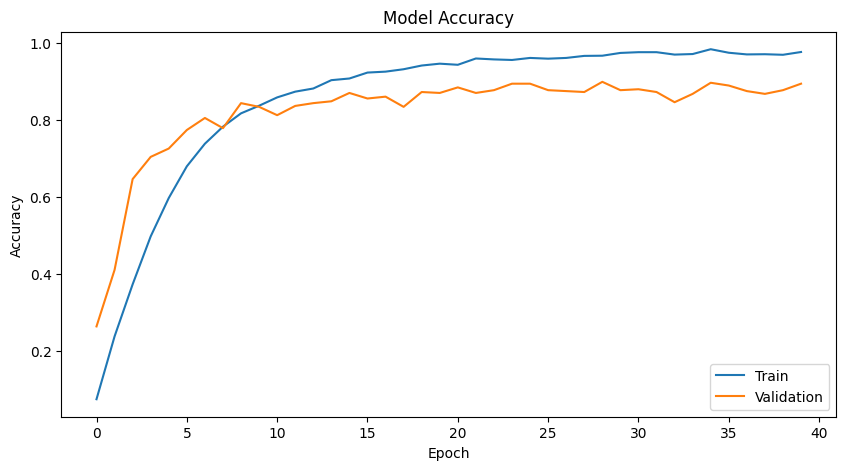

In [ ]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define the file path for saving the model
model_save_path_2 = 'mobilenet_card_classifier_model.keras'

# Add the ModelCheckpoint callback
model_checkpoint_2 = ModelCheckpoint(
    filepath=model_save_path_2,  # File path where the model will be saved
    monitor='val_accuracy',   # Metric to monitor
    save_best_only=True,      # Save only the best model based on validation accuracy
    mode='max'               # 'max' because we're looking for higher accuracy
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best weights after stopping
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint_2, early_stopping]
)

# Plot training & validation loss values
print(f"Model saved to: {model_save_path_2}")
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

# Load the saved model
saved_model = load_model(model_save_path_2)

# Shuffle and split the data into 80% for testing
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Evaluate or use the model
saved_model.evaluate(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - accuracy: 0.9744 - loss: 0.1011


[0.0786379873752594, 0.9800000190734863]